# Modeling and Simulation in Python

Chapter 3: Explain

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

Pandas is a module that provides tools for reading and processing data.  The `read_html` reads a web page from a file or the Internet and creates one DataFrame for each table on the page.

In [2]:
from pandas import read_html

The data directory contains a downloaded copy of https://en.wikipedia.org/wiki/World_population_estimates

In [3]:
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')

`tables` is a sequence of DataFrame objects.  We can select the DataFrame we want using the bracket operator.  The tables are numbered from 0, so `table2` is actually the third table on the page.

`head` selects the header and the first five rows.

In [4]:
table2 = tables[2]
table2.head()

,United States Census Bureau (2015)[18],Population Reference Bureau (1973–2015)[6],United Nations Department of Economic and Social Affairs (2015)[7],Maddison (2008)[8],HYDE (2007)[15],Tanton (1994)[9],Biraben (1980)[10],McEvedy & Jones (1978)[11],Thomlinson (1975)[12],Durand (1974)[13],Clark (1967)[14]
Year,,,,,,,,,,,
1950,2557628654,2.516000e+09,2525149000,2.544000e+09,2.527960e+09,2.400000e+09,2.527000e+09,2.500000e+09,2.400000e+09,NaN,2.486000e+09
1951,2594939877,NaN,2572850917,2.571663e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,2636772306,NaN,2619292068,2.617949e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,2682053389,NaN,2665865392,2.665959e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954,2730228104,NaN,2713172027,2.716927e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`tail` selects the last five rows.

In [5]:
table2.tail()

,United States Census Bureau (2015)[18],Population Reference Bureau (1973–2015)[6],United Nations Department of Economic and Social Affairs (2015)[7],Maddison (2008)[8],HYDE (2007)[15],Tanton (1994)[9],Biraben (1980)[10],McEvedy & Jones (1978)[11],Thomlinson (1975)[12],Durand (1974)[13],Clark (1967)[14]
Year,,,,,,,,,,,
2011,6944055583,6.986951e+09,6997998760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012,7022349283,7.057075e+09,7080072417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,7101027895,7.136796e+09,7162119434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,7178722893,7.238184e+09,7243784000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,7256490011,7.336435e+09,7349472000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Long column names are awkard to work with, but we can replace them with abbreviated names.

In [6]:
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

Here's what the DataFrame looks like now.  

Some of the values use scientific notation; for example, `2.544000e+09` is shorthand for $2.544 \cdot 10^9$ or 2.544 billion.

`NaN` is a special value that indicates missing data.

In [7]:
table2

,census,prb,un,maddison,hyde,tanton,biraben,mj,thomlinson,durand,clark
Year,,,,,,,,,,,
1950,2557628654,2.516000e+09,2525149000,2.544000e+09,2.527960e+09,2.400000e+09,2.527000e+09,2.500000e+09,2.400000e+09,NaN,2.486000e+09
1951,2594939877,NaN,2572850917,2.571663e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,2636772306,NaN,2619292068,2.617949e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,2682053389,NaN,2665865392,2.665959e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954,2730228104,NaN,2713172027,2.716927e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955,2782098943,NaN,2761650981,2.769074e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1956,2835299673,NaN,2811572031,2.822502e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957,2891349717,NaN,2863042795,2.879934e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958,2948137248,NaN,2916030167,2.939254e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can use dot notatio to select a column from a DataFrame.  The result is a Series.

In [8]:
census = table2.census
census

Year
1950    2557628654
1951    2594939877
1952    2636772306
1953    2682053389
1954    2730228104
1955    2782098943
1956    2835299673
1957    2891349717
1958    2948137248
1959    3000716593
1960    3043001508
1961    3083966929
1962    3140093217
1963    3209827882
1964    3281201306
1965    3350425793
1966    3420677923
1967    3490333715
1968    3562313822
1969    3637159050
1970    3712697742
1971    3790326948
1972    3866568653
1973    3942096442
1974    4016608813
1975    4089083233
1976    4160185010
1977    4232084578
1978    4304105753
1979    4379013942
           ...    
1986    4940571232
1987    5027200492
1988    5114557167
1989    5201440110
1990    5288955934
1991    5371585922
1992    5456136278
1993    5538268316
1994    5618682132
1995    5699202985
1996    5779440593
1997    5857972543
1998    5935213248
1999    6012074922
2000    6088571383
2001    6165219247
2002    6242016348
2003    6318590956
2004    6395699509
2005    6473044732
2006    6551263534
2007   

A Series object has two parts, `values` and `index`.

The `values` part is an array.

In [9]:
census.values

array([2557628654, 2594939877, 2636772306, 2682053389, 2730228104,
       2782098943, 2835299673, 2891349717, 2948137248, 3000716593,
       3043001508, 3083966929, 3140093217, 3209827882, 3281201306,
       3350425793, 3420677923, 3490333715, 3562313822, 3637159050,
       3712697742, 3790326948, 3866568653, 3942096442, 4016608813,
       4089083233, 4160185010, 4232084578, 4304105753, 4379013942,
       4451362735, 4534410125, 4614566561, 4695736743, 4774569391,
       4856462699, 4940571232, 5027200492, 5114557167, 5201440110,
       5288955934, 5371585922, 5456136278, 5538268316, 5618682132,
       5699202985, 5779440593, 5857972543, 5935213248, 6012074922,
       6088571383, 6165219247, 6242016348, 6318590956, 6395699509,
       6473044732, 6551263534, 6629913759, 6709049780, 6788214394,
       6866332358, 6944055583, 7022349283, 7101027895, 7178722893,
       7256490011], dtype=int64)

The `index` part is yet another kind of object, an `Int64Index`.

In [10]:
census.index

Int64Index([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
            1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
            1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
            1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
            1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
            2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015],
           dtype='int64', name='Year')

If you ever wonder what kind of object a variable refers to, you can use the `type` function.

The result indicates what type the object is, and the module where that type is defined.

DataFrame, Series, and Int64Index are defined by Pandas.

array is defined by NumPy.

In [11]:
type(table2)

pandas.core.frame.DataFrame

In [12]:
type(census)

pandas.core.series.Series

In [13]:
type(census.index)

pandas.core.indexes.numeric.Int64Index

In [14]:
type(census.values)

numpy.ndarray

This function plots the estimates generated by the US Censis and UN DESA, and labels the axes.

`1e9` is scientific notation for $1 \cdot 10^9$ or 1 billion.

In [15]:
def plot_estimates(table):
    """Plot world population estimates.
    
    table: DataFrame with columns 'un' and 'census'
    """
    un = table.un / 1e9
    census = table.census / 1e9
    
    plot(census, ':', color='darkblue', label='US Census')
    plot(un, '--', color='green', label='UN DESA')
    
    decorate(xlabel='Year',
             ylabel='World population (billion)')

Now we can plot the estimates.

Saving figure to file chap03-fig01.pdf


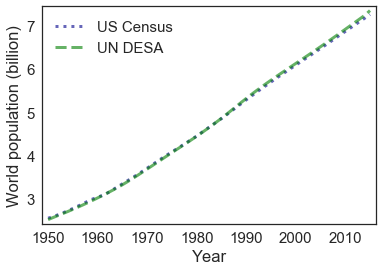

In [16]:
newfig()
plot_estimates(table2)
savefig('chap03-fig01.pdf')

From here on, we will work in units of billions.

In [17]:
un = table2.un / 1e9

In [18]:
census = table2.census / 1e9

This expression computes the elementwise differences between the series, then divides through by the UN value to produce relative errors, then finds the largest element.

So the largest relative error between the estimates is about 1.3%.

In [19]:
max(abs(census - un) / un) * 100

1.2862470293832287

**Exercise:** Break down that expression into smaller steps and display the intermediate results, to make sure you understand how it works.

Where in the series is the largest relative error between the two estimates, near the beginning or the end? It is further away for longer time in the beginning but a bigger difference in the end

When I computed relative errors, I used `un` as the denominator.  But that was an arbitraty choice.  What happens if we use `census` instead?  How much difference does it make. .005

In [20]:
abs(census - un)

Year
1950    0.032480
1951    0.022089
1952    0.017480
1953    0.016188
1954    0.017056
1955    0.020448
1956    0.023728
1957    0.028307
1958    0.032107
1959    0.030321
1960    0.016999
1961    0.001137
1962    0.000978
1963    0.008650
1964    0.017462
1965    0.021303
1966    0.023203
1967    0.021812
1968    0.020639
1969    0.021050
1970    0.021525
1971    0.023573
1972    0.023695
1973    0.022914
1974    0.021304
1975    0.018063
1976    0.014049
1977    0.011268
1978    0.008441
1979    0.007486
          ...   
1986    0.012805
1987    0.018115
1988    0.023658
1989    0.028560
1990    0.031861
1991    0.037323
1992    0.038763
1993    0.040597
1994    0.042404
1995    0.042619
1996    0.041576
1997    0.040716
1998    0.040090
1999    0.039403
2000    0.039129
2001    0.038928
2002    0.038837
2003    0.039401
2004    0.040006
2005    0.041050
2006    0.041964
2007    0.043192
2008    0.044599
2009    0.046508
2010    0.049851
2011    0.053943
2012    0.057723
2013    0

In [21]:
abs(census - un) / un

Year
1950    0.012862
1951    0.008585
1952    0.006674
1953    0.006072
1954    0.006286
1955    0.007404
1956    0.008439
1957    0.009887
1958    0.011011
1959    0.010208
1960    0.005617
1961    0.000369
1962    0.000311
1963    0.002702
1964    0.005350
1965    0.006399
1966    0.006829
1967    0.006289
1968    0.005827
1969    0.005821
1970    0.005832
1971    0.006258
1972    0.006166
1973    0.005847
1974    0.005332
1975    0.004437
1976    0.003388
1977    0.002670
1978    0.001965
1979    0.001712
          ...   
1986    0.002585
1987    0.003591
1988    0.004604
1989    0.005461
1990    0.005988
1991    0.006900
1992    0.007054
1993    0.007277
1994    0.007490
1995    0.007423
1996    0.007142
1997    0.006903
1998    0.006709
1999    0.006511
2000    0.006386
2001    0.006274
2002    0.006183
2003    0.006197
2004    0.006216
2005    0.006302
2006    0.006365
2007    0.006473
2008    0.006604
2009    0.006805
2010    0.007208
2011    0.007708
2012    0.008153
2013    0

In [22]:
abs(census - un) / un

Year
1950    0.012862
1951    0.008585
1952    0.006674
1953    0.006072
1954    0.006286
1955    0.007404
1956    0.008439
1957    0.009887
1958    0.011011
1959    0.010208
1960    0.005617
1961    0.000369
1962    0.000311
1963    0.002702
1964    0.005350
1965    0.006399
1966    0.006829
1967    0.006289
1968    0.005827
1969    0.005821
1970    0.005832
1971    0.006258
1972    0.006166
1973    0.005847
1974    0.005332
1975    0.004437
1976    0.003388
1977    0.002670
1978    0.001965
1979    0.001712
          ...   
1986    0.002585
1987    0.003591
1988    0.004604
1989    0.005461
1990    0.005988
1991    0.006900
1992    0.007054
1993    0.007277
1994    0.007490
1995    0.007423
1996    0.007142
1997    0.006903
1998    0.006709
1999    0.006511
2000    0.006386
2001    0.006274
2002    0.006183
2003    0.006197
2004    0.006216
2005    0.006302
2006    0.006365
2007    0.006473
2008    0.006604
2009    0.006805
2010    0.007208
2011    0.007708
2012    0.008153
2013    0

In [23]:
(abs(census - un) / un) * 100

Year
1950    1.286247
1951    0.858540
1952    0.667365
1953    0.607232
1954    0.628640
1955    0.740425
1956    0.843928
1957    0.988701
1958    1.101054
1959    1.020766
1960    0.561750
1961    0.036871
1962    0.031146
1963    0.270201
1964    0.535045
1965    0.639908
1966    0.682939
1967    0.628856
1968    0.582745
1969    0.582126
1970    0.583151
1971    0.625807
1972    0.616597
1973    0.584666
1974    0.533223
1975    0.443692
1976    0.338849
1977    0.266959
1978    0.196499
1979    0.171246
          ...   
1986    0.258520
1987    0.359053
1988    0.460423
1989    0.546078
1990    0.598794
1991    0.690025
1992    0.705441
1993    0.727689
1994    0.749047
1995    0.742263
1996    0.714242
1997    0.690252
1998    0.670935
1999    0.651132
2000    0.638560
2001    0.627448
2002    0.618347
2003    0.619705
2004    0.621627
2005    0.630170
2006    0.636478
2007    0.647257
2008    0.660376
2009    0.680460
2010    0.720789
2011    0.770837
2012    0.815290
2013    0

### Constant growth

We can select an element from a series using bracket notation and one of the elements from the index.  Here's the first element:

In [24]:
census[1950]

2.5576286540000002

And the last element.

In [25]:
census[2015]

7.2564900110000004

But we can get the first and last years from the index itself:

In [26]:
first_year = census.index[0]
last_year = census.index[-1]
first_year, last_year

(1950, 2015)

And use them to look up the first and last elements.

Then we can compute the average annual growth in billions of people per year.

In [27]:
total_growth = census[last_year] - census[first_year]
elapsed_time = last_year - first_year
annual_growth = total_growth / elapsed_time
annual_growth

0.07229017472307693

Now let's create a `TimeSeries` to contain values generated by a linear growth model.

In [28]:
results = TimeSeries()

Initially the Series is empty, but we can initialize it so the starting value, in 1950, is the 1950 population estimated by the US Census.

In [29]:
results[1950] = census[1950]
results

,value
1950,2.557629


After that, the population in the model grows by a constant amount each year.

In [30]:
for t in linrange(1950, 2015):
    results[t+1] = results[t] + annual_growth

Here's what the results looks like, compared to the actual data.

Saving figure to file chap03-fig02.pdf


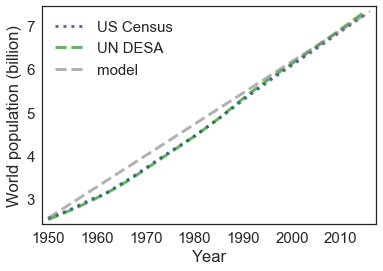

In [31]:
newfig()
plot_estimates(table2)
plot(results, '--', color='gray', label='model')
decorate(xlabel='Year', ylabel='World population (billion)')
savefig('chap03-fig02.pdf')

The model fits the data pretty well after 1990, but not so well before.

**Exercise:**  Try fitting the model using data from 1965 to the present, and see if that does a better job.

Hint: Copy the code from above and make a few changes.

Make sure your model starts in 1950, even though the estimated annual growth is based on later data.  You might have to shift the first value in the series up or down to match the data.

Saving figure to file chap03-fig02.1.pdf


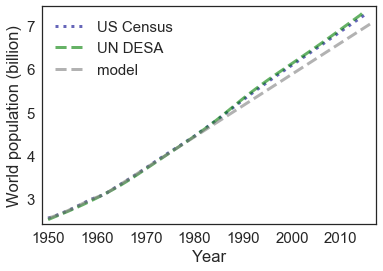

In [32]:

results = TimeSeries()

for t in linrange(1950, 1965):
    results[t] = census[t]
    
for t in linrange(1965, 2015):
    results[t+1] = results[t] + annual_growth


newfig()
plot_estimates(table2)
plot(results, '--', color='gray', label='model')
decorate(xlabel='Year', ylabel='World population (billion)')
savefig('chap03-fig02.1.pdf')

### Now with system objects

We can rewrite the code from the previous section using system objects.

In [33]:
t0 = census.index[0]
t_end = census.index[-1]
total_growth = census[t_end] - census[t0]
elapsed_time = t_end - t0
annual_growth = total_growth / elapsed_time

Here's the system object.

In [41]:
system = System(t0=t0, 
                t_end=t_end,
                p0=census[t0],
                annual_growth=annual_growth)

And we can encapsulate the code tha runs the model in a function that stores the resulting Series as a new system variable.

In [42]:
def run_simulation1(system):
    """Runs the constant growth model.
    
    Adds TimeSeries to `system` as `results`.
    
    system: system object
    """
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    system.results = results

We can also encapsulate the code that plots the results.

In [43]:
def plot_results(system, title=None):
    """Plot the estimates and the model.
    
    system: System object with `results`
    """
    newfig()
    plot_estimates(table2)
    plot(system.results, '--', color='gray', label='model')
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

Here's how we run it.

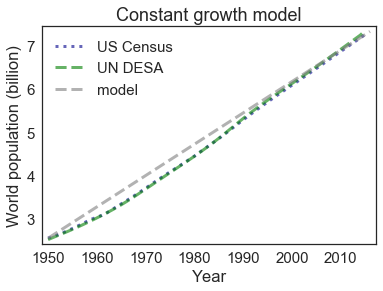

In [44]:
run_simulation1(system)
plot_results(system, title='Constant growth model')

`plot_results` uses `decorate`, which takes parameters that specify the title of the figure, labels for the $x$ and $y$ axis, and limits for the axes.  To read the documentation of `decorate`, run the cells below.

In [45]:
help(decorate)

Help on function decorate in module modsim:

decorate(**kwargs)
    Decorate the current axes.
    
    Call decorate with keyword arguments like
    
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    
    The keyword arguments can be any of the axis properties
    defined by Matplotlib.  To see the list, run plt.getp(plt.gca())
    
    In addition, you can use `legend=False` to suppress the legend.
    
    And you can use `loc` to indicate the location of the legend
    (the default value is 'best')



    adjustable = box
    agg_filter = None
    alpha = None
    anchor = C
    animated = False
    aspect = auto
    autoscale_on = True
    autoscalex_on = True
    autoscaley_on = True
    axes = Axes(0.125,0.125;0.775x0.755)
    axes_locator = None
    axis_bgcolor = (1.0, 1.0, 1.0, 1.0)
    axisbelow = True
    children = [<matplotlib.spines.Spine object at 0x000001A9E699...
    clip_box = None
    clip_on = True
    clip_path = None
    contains = None
    cursor_props = (1, (0.0, 0.0, 0.0, 1))
    data_ratio = 1.0
    default_bbox_extra_artists = [<matplotlib.spines.Spine object at 0x000001A9E699...
    facecolor = (1.0, 1.0, 1.0, 1.0)
    fc = (1.0, 1.0, 1.0, 1.0)
    figure = Figure(432x288)
    frame_on = True
    geometry = (1, 1, 1)
    gid = None
    images = <a list of 0 AxesImage objects>
    label = 
    legend = None
    legend_handles_labels = ([], [])
    lines = <a list of 0 Line2D objects>
    navigate = True
    navigate_mode = None
    path_effects = []
    picke

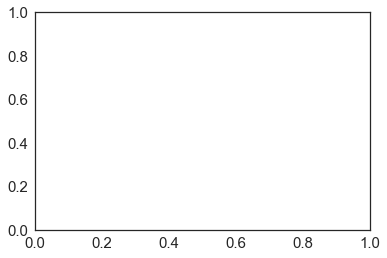

In [46]:
plt.getp(plt.gca())

**Exercise:** The constant growth model doesn't make a lot of sense, because it seems like the number of deaths and births should depend on the size of the population.  As a small improvement, let's write a version of `run_simulation1` where the number of deaths is proportional to the size of the population, but the number of births is constant.  This model doesn't make a lot of sense, either, but it's a good exercise.

Write a function called `run_simulation1b` that implements a model where the number of births is constant, but the number of deaths is proportional to the current size of the population.  Set the death rate to `0.01`, which means that 1% of the population dies each year; then choose the number of annual births to make the model fit the data as well as you can.

Hint: It probably won't fit very well.

In [47]:
def run_simulation1(system):
    """Runs the constant growth model.
    
    Adds TimeSeries to `system` as `results`.
    
    system: system object
    """
    death = .01 * system.p0
    births = .02
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        results[t+1] = results[t] + system.annual_growth - death + births
    system.results = results
    

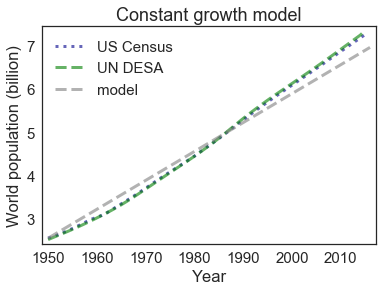

In [48]:
run_simulation1(system)
plot_results(system, title='Constant growth model')

## Proportional death, proportional birth

Now let's get to a more realistic model where the number of births and deaths is proportional to the current population.

In [61]:
def run_simulation2(system):
    """Runs the constant growth model.
    
    Adds TimeSeries to `system` as `results`.
    
    system: system object
    """
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
    system.results = results

I kept the death rate at 1% and chose the birth rate to fit the data.

In [62]:
system.death_rate = 0.01
system.birth_rate = 0.027

Here's what it looks like.

Saving figure to file chap03-fig03.pdf


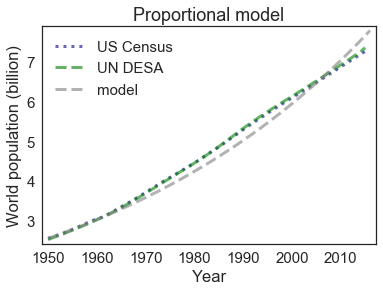

In [63]:
run_simulation2(system)
plot_results(system, title='Proportional model')
savefig('chap03-fig03.pdf')

The model fits the data pretty well for the first 20 years, but not so well after that.

**Exercise:** In this implementation, we compute the number of deaths and births separately, but since they are both proportional to the current population, we can combine them.

Write a function called `run_simulation2b` that implements a model with a single parameter, `alpha`, that represents the net growth rate, which is the difference between the birth and death rates.  For example, if `alpha=0.01`, the population should grow by 1% per year.

Choose the value of `alpha` that fits the data best.

In [64]:
def run_simulation2b(alpha):
     results = TimeSeries()
     results[system.t0] = system.p0
     for t in linrange(system.t0, system.t_end):
        net = alpha * results[t]
        results[t+1] = results[t] + net
     system.results = results

Saving figure to file chap03-fig03.1.pdf


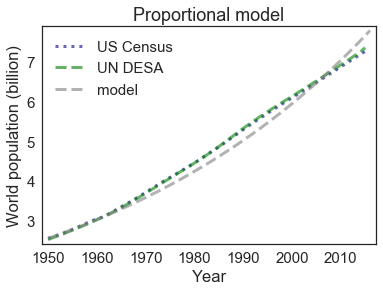

In [65]:
run_simulation2b(0.017)
plot_results(system, title='Proportional model')
savefig('chap03-fig03.1.pdf')

### Factoring out the update function

The functions that run the model all look the same except the body of the loop.  So we can factor that part out into a function.

In [66]:
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    print(t, pop)
    return pop + births - deaths

Now the name `update_func1` refers to a function object.

In [67]:
update_func1

<function __main__.update_func1>

Which we can confirm by checking its type.

In [68]:
type(update_func1)

function

`run_simulation` takes the update function as a parameter and calls it just like any other function.

In [69]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    Adds TimeSeries to `system` as `results`.

    system: System object
    update_func: function that computes the population next year
    """
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
    system.results = results

Here's how we use it.

In [70]:
run_simulation(system, update_func1)

1950.0 2.557628654
1951.0 2.60110834112
1952.0 2.64532718292
1953.0 2.69029774503
1954.0 2.73603280669
1955.0 2.78254536441
1956.0 2.8298486356
1957.0 2.87795606241
1958.0 2.92688131547
1959.0 2.97663829783
1960.0 3.02724114889
1961.0 3.07870424842
1962.0 3.13104222065
1963.0 3.1842699384
1964.0 3.23840252735
1965.0 3.29345537032
1966.0 3.34944411161
1967.0 3.40638466151
1968.0 3.46429320075
1969.0 3.52318618517
1970.0 3.58308035032
1971.0 3.64399271627
1972.0 3.70594059245
1973.0 3.76894158252
1974.0 3.83301358942
1975.0 3.89817482044
1976.0 3.96444379239
1977.0 4.03183933686
1978.0 4.10038060559
1979.0 4.17008707588
1980.0 4.24097855617
1981.0 4.31307519163
1982.0 4.38639746988
1983.0 4.46096622687
1984.0 4.53680265273
1985.0 4.61392829783
1986.0 4.69236507889
1987.0 4.77213528523
1988.0 4.85326158508
1989.0 4.93576703202
1990.0 5.01967507157
1991.0 5.10500954779
1992.0 5.1917947101
1993.0 5.28005522017
1994.0 5.36981615891
1995.0 5.46110303361
1996.0 5.55394178519
1997.0 5.648358795

Remember not to put parentheses after `update_func1`.  What happens if you try?

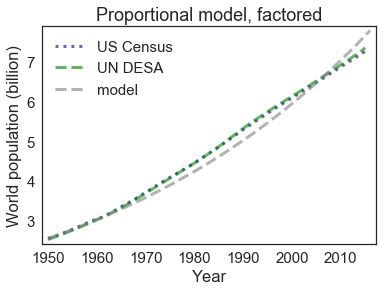

In [71]:
plot_results(system, title='Proportional model, factored')

**Exercise:** When you run `run_simulation`, it runs `update_func1` once for each year between `t0` and `t_end`.  To see that for yourself, add a print statement at the beginning of `update_func1` that prints the values of `t` and `pop`, then run `run_simulation` again.

### Combining birth and death

Since births and deaths get added up, we don't have to compute them separately.  We can combine the birth and death rates into a single net growth rate.

In [72]:
def update_func1b(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
   
    
    net_growth = system.alpha  * pop
    return pop + net_growth

Here's how it works:

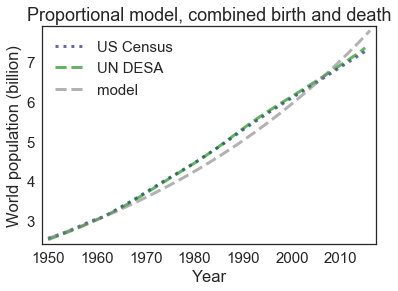

In [73]:
system.alpha = system.birth_rate - system.death_rate

run_simulation(system, update_func1b)
plot_results(system, title='Proportional model, combined birth and death')

**Exercise:** Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, might be changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write a function called `update_func1c` that takes `pop`, `t`, and `system` as parameters.  The system object, `system`, should contains two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should compute and return the simulated population one year later.

Note: Don't forget the `return` statement.

In [75]:
def update_func1c(pop, t, system):
    if t<1980:
        netgrowth = (system.alpha1  * pop)
    else:
        netgrowth= (system.alpha2  * pop)
    
     
    return pop +netgrowth

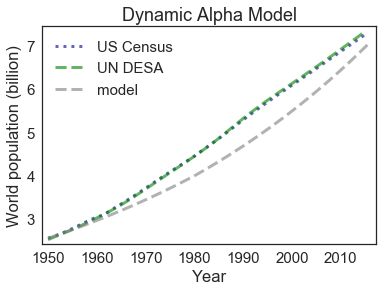

In [76]:
system.alpha1=0.015
system.alpha2=0.016

run_simulation(system,update_func1c)
plot_results(system,title='Dynamic Alpha Model')

### Quadratic growth

Here's the implementation of the quadratic growth model.

In [77]:
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha * pop + system.beta * pop**2
    return pop + net_growth

And here are the results.  Can you find values for the parameters that make the model fit better?

Saving figure to file chap03-fig04.pdf


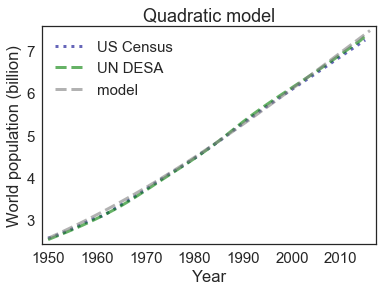

In [78]:
system.alpha = 0.025
system.beta = -0.0018

run_simulation(system, update_func2)
plot_results(system, title='Quadratic model')
savefig('chap03-fig04.pdf')

To understand the quadratic model better, let's plot net growth as a function of population.

In [80]:
pop_array = linspace(0.001, 15, 100)
net_growth_array = system.alpha * pop_array + system.beta * pop_array**2

Here's what it looks like.  Remember that the x axis is population now, not time.

The function `sns.set` sets the style for the plots.  I added a grid to this one to make it easier to read.

Saving figure to file chap03-fig05.pdf


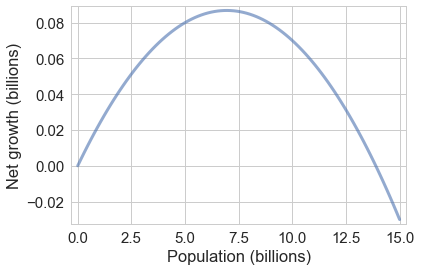

In [81]:
newfig()
sns.set(style='whitegrid', font_scale=1.5)
plot(pop_array, net_growth_array, '-')
decorate(xlabel='Population (billions)',
         ylabel='Net growth (billions)',
         legend=False)
savefig('chap03-fig05.pdf')

Using `sns.set` to reset the plot style.

In [82]:
sns.set(style='white', font_scale=1.5)

In the book we found that the net growth is 0 when the population is $-\alpha/\beta$:

In [83]:
-system.alpha / system.beta

13.88888888888889

This is the equilibrium the population tends toward.

**Exercise:** In the book, I presented a different way to parameterize the quadratic model:

$ \Delta p = r p (1 - p / K) $

where $r=\alpha$ and $K=-\alpha/\beta$.  Write a version of `update_func2` that implements this version of the model.  Test it by computing system variables `r` and `K` equivalent to `alpha` and `beta`, and confirm that you get the same results. 

In [84]:
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    r=system.alpha
    k=-system.alpha/system.beta
    print(r,k)
    
    net_growth = r * pop * (1 - pop / k)
    return pop + net_growth

0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.88888888888889
0.025 13.8888888

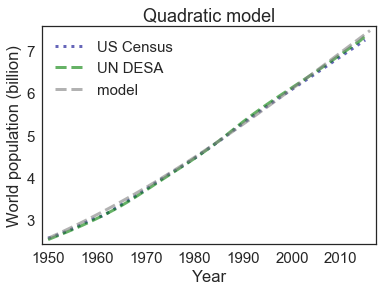

In [85]:
system.alpha = 0.025
system.beta = -0.0018

run_simulation(system, update_func2)
plot_results(system, title='Quadratic model')
savefig('chap03-fig04.1.pdf')

**Exercise:** On the Wikipedia page about world population estimates, the first table contains estimates for prehistoric populations.  The following cells process this table and plot some of the results.

Select `table1`, which is the second table on the page.

In [86]:
table1 = tables[1]
table1.head()

,Population Reference Bureau (1973–2015)[6],United Nations Department of Economic and Social Affairs (2015)[7],Maddison (2008)[8],HYDE (2010)[citation needed],Tanton (1994)[9],Biraben (1980)[10],McEvedy & Jones (1978)[11],Thomlinson (1975)[12],Durand (1974)[13],Clark (1967)[14]
Year,,,,,,,,,,
-10000,NaN,NaN,NaN,2M[15],NaN,NaN,4.0,1–10M,NaN,NaN
-9000,NaN,NaN,NaN,4.,NaN,NaN,NaN,NaN,NaN,NaN
-8000,5.0,NaN,NaN,5.,NaN,NaN,NaN,NaN,5–10M,NaN
-7000,NaN,NaN,NaN,8.,NaN,NaN,NaN,NaN,NaN,NaN
-6000,NaN,NaN,NaN,11.,NaN,NaN,NaN,NaN,NaN,NaN


Not all agencies and researchers provided estimates for the same dates.  Again `NaN` is the special value that indicates missing data.

In [87]:
table1.tail()

,Population Reference Bureau (1973–2015)[6],United Nations Department of Economic and Social Affairs (2015)[7],Maddison (2008)[8],HYDE (2010)[citation needed],Tanton (1994)[9],Biraben (1980)[10],McEvedy & Jones (1978)[11],Thomlinson (1975)[12],Durand (1974)[13],Clark (1967)[14]
Year,,,,,,,,,,
1913,NaN,NaN,1793.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920,NaN,1860.0,1863.,1912.,NaN,NaN,NaN,NaN,NaN,1968.
1925,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,NaN,NaN
1930,NaN,2070.0,NaN,2092.,NaN,NaN,NaN,NaN,NaN,2145.
1940,NaN,2300.0,2299.,2307.,NaN,NaN,NaN,NaN,NaN,2340.


Some of the estimates are in a form we can't read as numbers.  We could clean them up by hand, but for simplicity I'll replace any value that has an `M` in it with `NaN`.

In [88]:
table1

,Population Reference Bureau (1973–2015)[6],United Nations Department of Economic and Social Affairs (2015)[7],Maddison (2008)[8],HYDE (2010)[citation needed],Tanton (1994)[9],Biraben (1980)[10],McEvedy & Jones (1978)[11],Thomlinson (1975)[12],Durand (1974)[13],Clark (1967)[14]
Year,,,,,,,,,,
-10000,NaN,NaN,NaN,2M[15],NaN,NaN,4.0,1–10M,NaN,NaN
-9000,NaN,NaN,NaN,4.,NaN,NaN,NaN,NaN,NaN,NaN
-8000,5.0,NaN,NaN,5.,NaN,NaN,NaN,NaN,5–10M,NaN
-7000,NaN,NaN,NaN,8.,NaN,NaN,NaN,NaN,NaN,NaN
-6000,NaN,NaN,NaN,11.,NaN,NaN,NaN,NaN,NaN,NaN
-5000,NaN,NaN,NaN,18M[15],NaN,NaN,5.0,5–20M,NaN,NaN
-4000,NaN,NaN,NaN,28.,NaN,NaN,7.0,NaN,NaN,NaN
-3000,NaN,NaN,NaN,45.,NaN,NaN,14.0,NaN,NaN,NaN
-2000,NaN,NaN,NaN,72.,NaN,NaN,27.0,NaN,NaN,NaN


In [89]:
table1.replace('M', np.nan, regex=True, inplace=True)

Again, we'll replace the long column names with more convenient abbreviations.

In [90]:
table1.columns = ['prb', 'un', 'maddison', 'hyde', 'tanton', 
                  'biraben', 'mj', 'thomlinson', 'durand', 'clark']

This function plots selected estimates.

In [91]:
def plot_prehistory(table):
    """Plots population estimates.
    
    table: DataFrame
    """
    plot(table.prb, 'ro', label='PRB')
    plot(table.un, 'co', label='UN')
    plot(table.hyde, 'yo', label='HYDE')
    plot(table.tanton, 'go', label='Tanton')
    plot(table.biraben, 'bo', label='Biraben')
    plot(table.mj, 'mo', label='McEvedy & Jones')

Here are the results.  Notice that we are working in millions now, not billions.

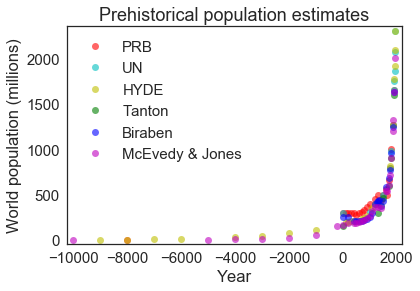

In [92]:
newfig()
plot_prehistory(table1)
decorate(xlabel='Year', 
         ylabel='World population (millions)',
         title='Prehistorical population estimates')


We can use `xlim` to zoom in on everything after Year 0.

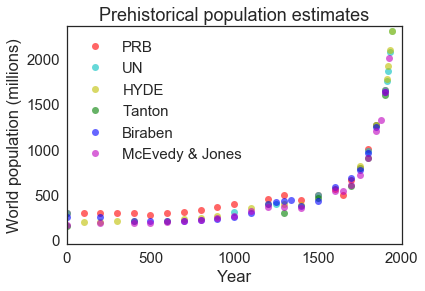

In [93]:
newfig()
plot_prehistory(table1)
decorate(xlim=[0, 2000], xlabel='Year', 
         ylabel='World population (millions)',
         title='Prehistorical population estimates')

See if you can find a model that fits these data well from Year -1000 to 1940, or from Year 0 to 1940.

How well does your best model predict actual population growth from 1950 to the present?

In [ ]:
"""def update_func3(pop, system):

    r=system.alpha
    k=-system.alpha/system.beta
    
    net_growth = r * pop * (1 - pop / k)
    return pop + net_growth

system=System(t0=-1000,
                t_end=1940,
                p0=table1.hyde[-1000], alpha=0.02, beta=-0.0018)"""

In [ ]:
#def run_simulation(system, update_func):
"""Simulate the system using any update function.
    
    Adds TimeSeries to `system` as `results`.

    system: System object
    update_func: function that computes the population next year
    
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
    system.results = results



run_simulation(system, update_func3)
decorate(xlim=[0, 2000], xlabel='Year', 
         ylabel='World population (millions)',
         title='Prehistorical population Model')"""


In [94]:
model = TimeSeries()
r=1.00065
k=-.0018
model[-1000] = 75
for t in linrange(-1000, 1940):
    #model[t+1] = model[t] * r *(1 - model[t]/k)   runtime error
    model[t+1] = model[t] * r 
    #model[t+1]=model[t]**1.00014                ok but not fantastic
    


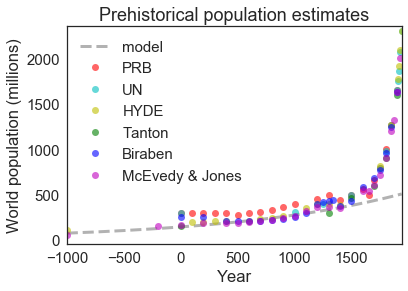

In [95]:
newfig()
plot(model, '--', color='gray', label='model')
plot_prehistory(table1)
decorate(xlim=[-1000, 1940], xlabel='Year', 
         ylabel='World population (millions)',
         title='Prehistorical population estimates')


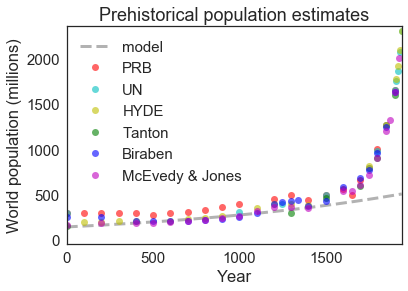

In [96]:
newfig()
plot(model, '--', color='gray', label='model')
plot_prehistory(table1)
decorate(xlim=[0, 1940], xlabel='Year', 
         ylabel='World population (millions)',
         title='Prehistorical population estimates')
